<a href="https://colab.research.google.com/github/AlexBorealis/netology_tsml_hw/blob/master/kozlov_tsml_hw_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [400]:
pd.read_csv("monthly-boston-armed-robberies-j.csv")

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43
...,...,...
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431


In [248]:
series = pd.read_csv("monthly-boston-armed-robberies-j.csv")['Count']

class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    dfoutput = dfoutput.to_frame().reset_index()
    dfoutput.columns = ['parameters', 'value']
    return dfoutput

def tsplot(y, lags= None, figsize= (12, 6), style= 'bmh', plot_name= None):
    print(test_stationarity(y))
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan= 2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax= ts_ax, color= 'blue', label= 'Or')
        ts_ax.set_title(plot_name)

        smt.graphics.plot_acf(y, lags= lags, ax= acf_ax, alpha= .05)
        smt.graphics.plot_pacf(y, lags= lags, ax= pacf_ax, alpha= .05)
        sm.qqplot(y, line= 's', ax= qq_ax)

        plt.tight_layout()
    return fig

                    parameters       value
0               Test Statistic    1.001102
1                      p-value    0.994278
2                    Lags Used   11.000000
3  Number of Observations Used  106.000000
4          Critical Value (1%)   -3.493602
5          Critical Value (5%)   -2.889217
6         Critical Value (10%)   -2.581533


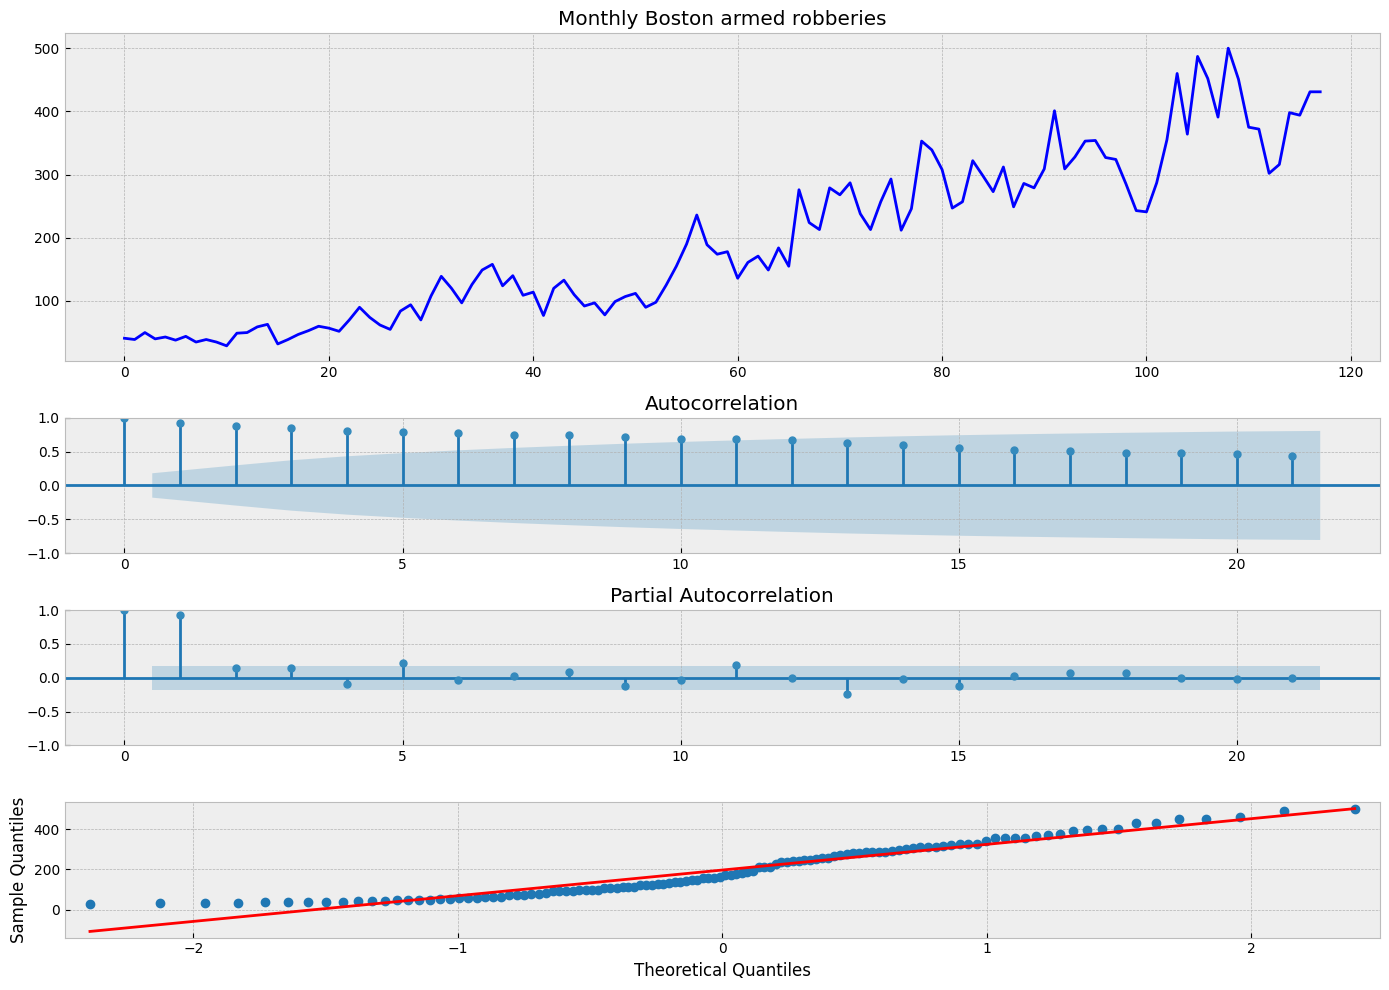

In [249]:
init_plot = tsplot(series, figsize= (14, 10), plot_name= 'Monthly Boston armed robberies')

# **L = 8**

In [250]:
boston_ts_8 = SSA(tseries= series, L= 8)

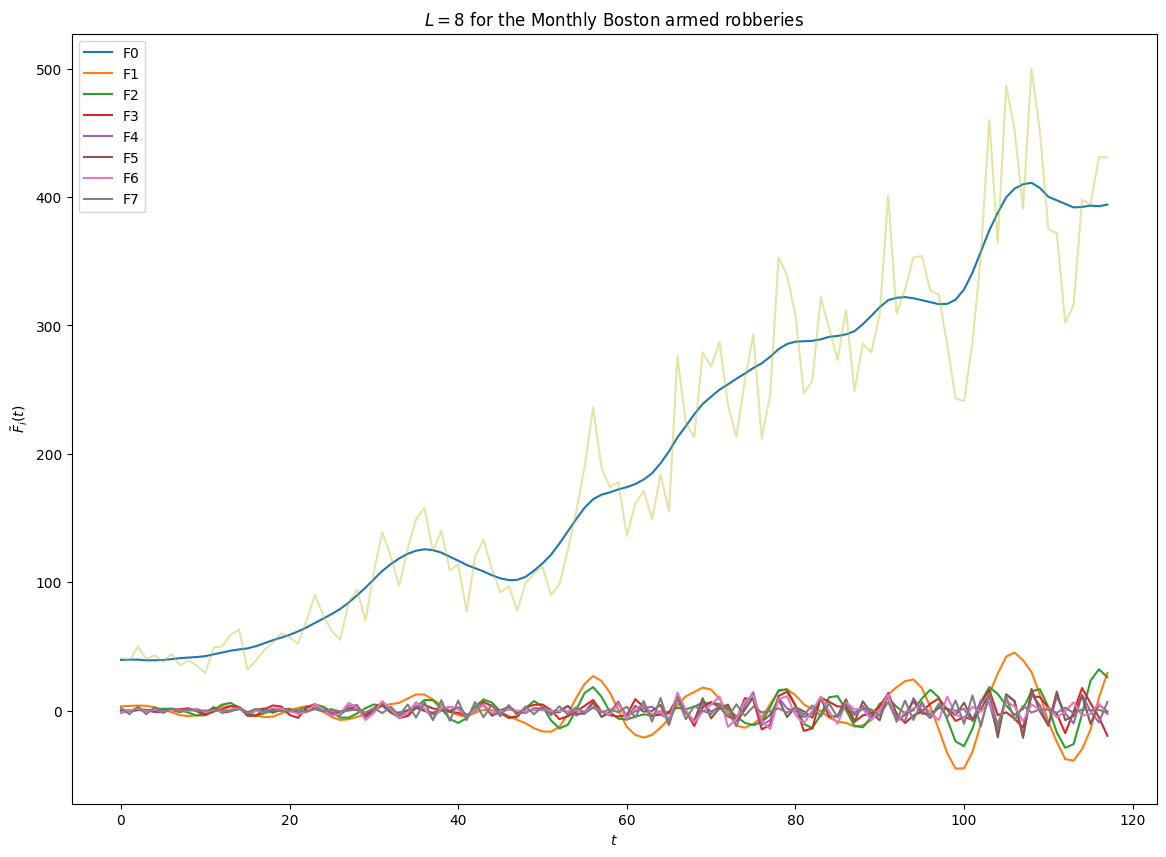

In [251]:
fig, ax = plt.subplots(figsize= (14, 10))

boston_ts_8.components_to_df().plot(ax= ax)
boston_ts_8.orig_TS.plot(ax= ax, alpha= .4)

ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tilde{F}_i(t)$")
ax.set_title(r"$L=8$ for the Monthly Boston armed robberies")

plt.show()

Text(0.5, 1.0, 'W-Correlation for the Monthly Boston armed robberies, $L=8$')

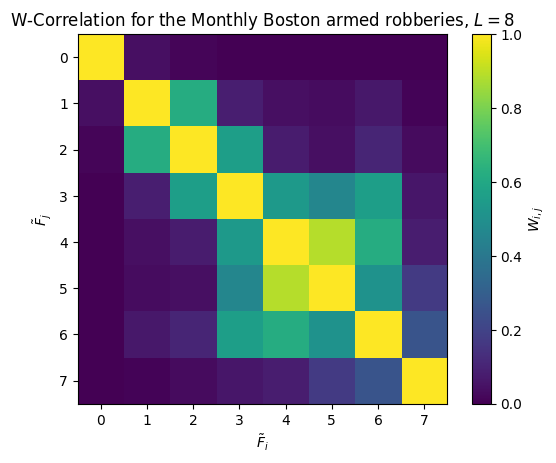

In [252]:
boston_ts_8.plot_wcorr()
plt.title("W-Correlation for the Monthly Boston armed robberies, $L=8$")

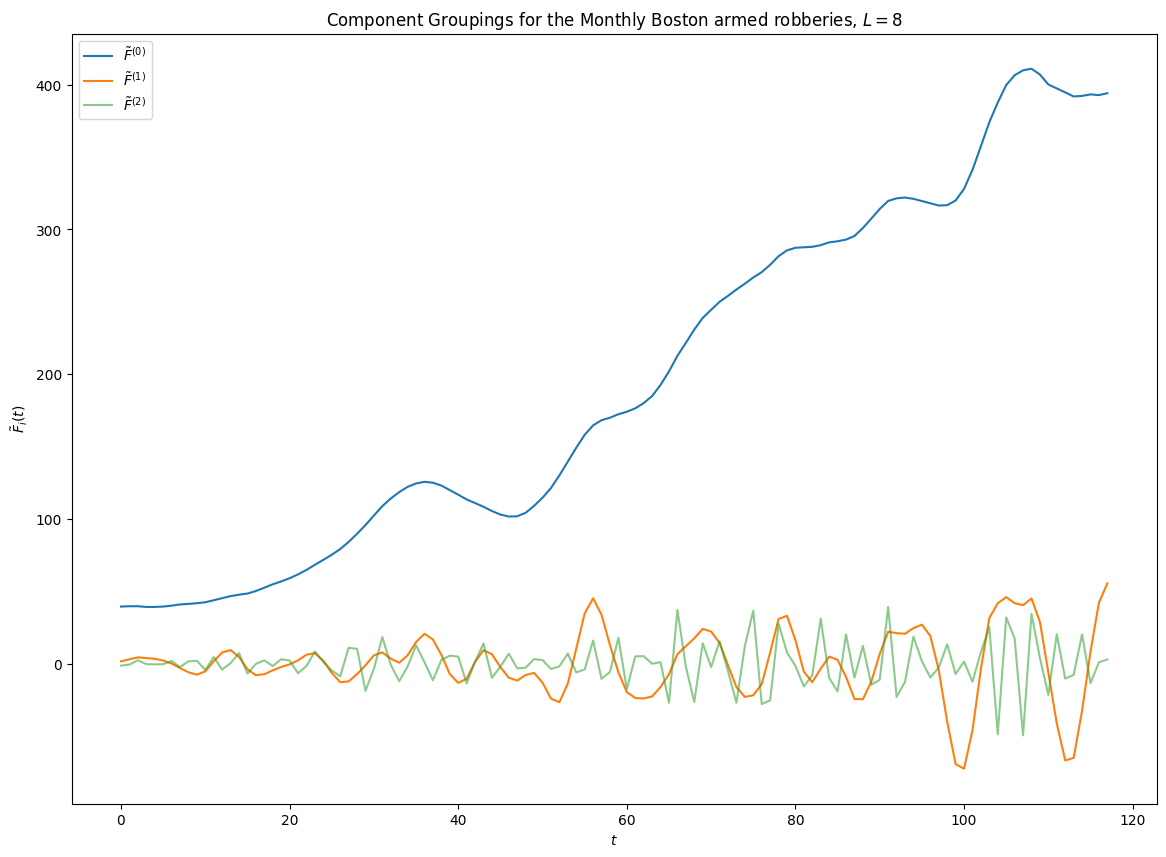

In [377]:
fig, ax = plt.subplots(figsize= (14, 10))

boston_ts_8.reconstruct(0).plot(ax= ax)
boston_ts_8.reconstruct(slice(1, 3)).plot(ax= ax)
boston_ts_8.reconstruct(slice(4, 7)).plot(alpha= .55, ax= ax)

plt.title("Component Groupings for the Monthly Boston armed robberies, $L=8$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)])

# **L = 16**

In [254]:
boston_ts_16 = SSA(tseries= series, L= 16)

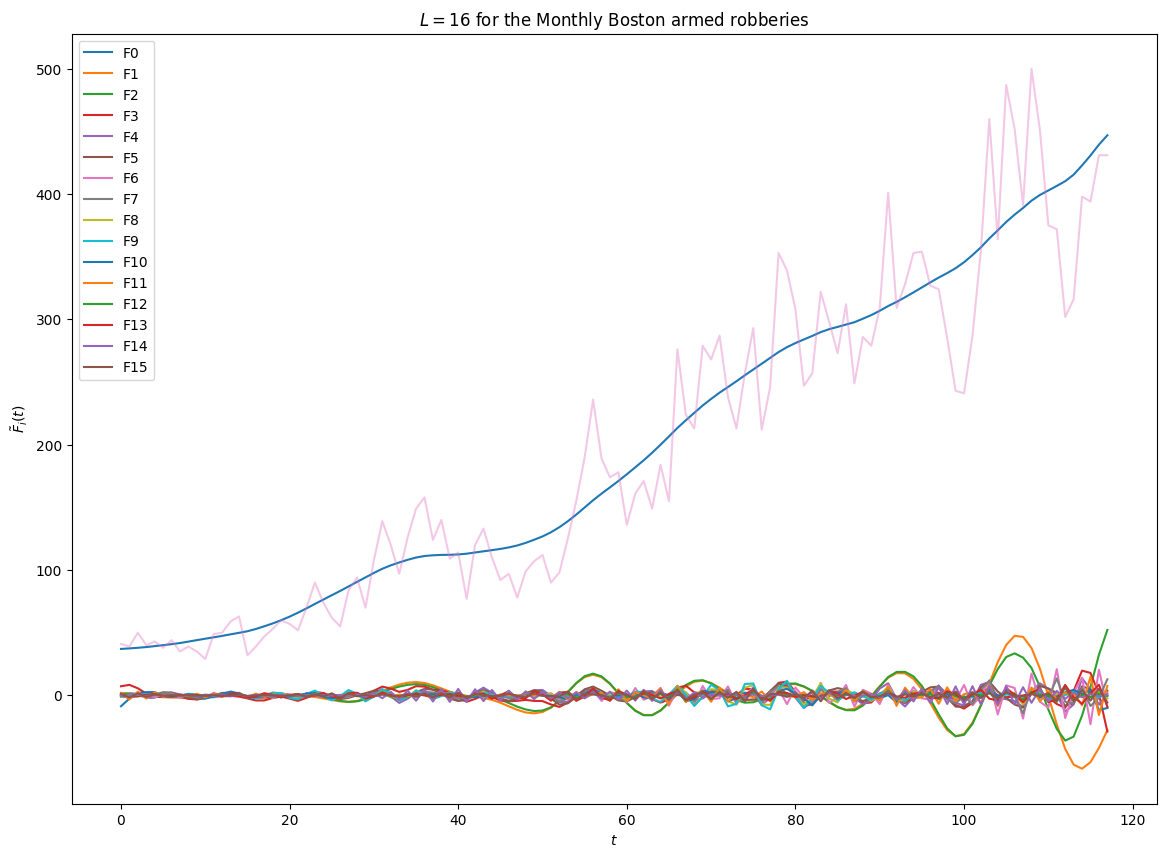

In [255]:
fig, ax = plt.subplots(figsize= (14, 10))

boston_ts_16.components_to_df().plot(ax= ax)
boston_ts_16.orig_TS.plot(ax= ax, alpha= .4)

ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tilde{F}_i(t)$")
ax.set_title(r"$L=16$ for the Monthly Boston armed robberies")

plt.show()

Text(0.5, 1.0, 'W-Correlation for the Monthly Boston armed robberies, $L=16$')

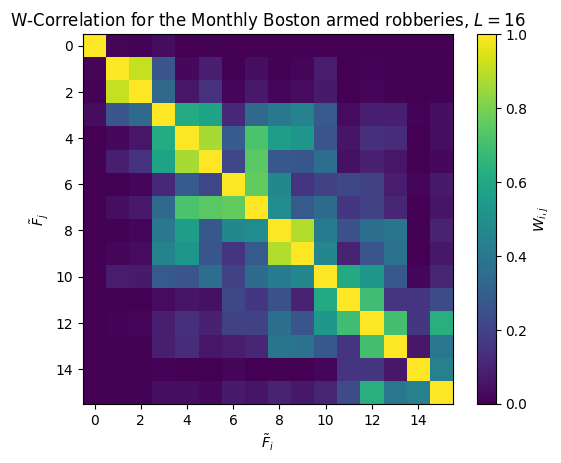

In [256]:
boston_ts_16.plot_wcorr()
plt.title("W-Correlation for the Monthly Boston armed robberies, $L=16$")

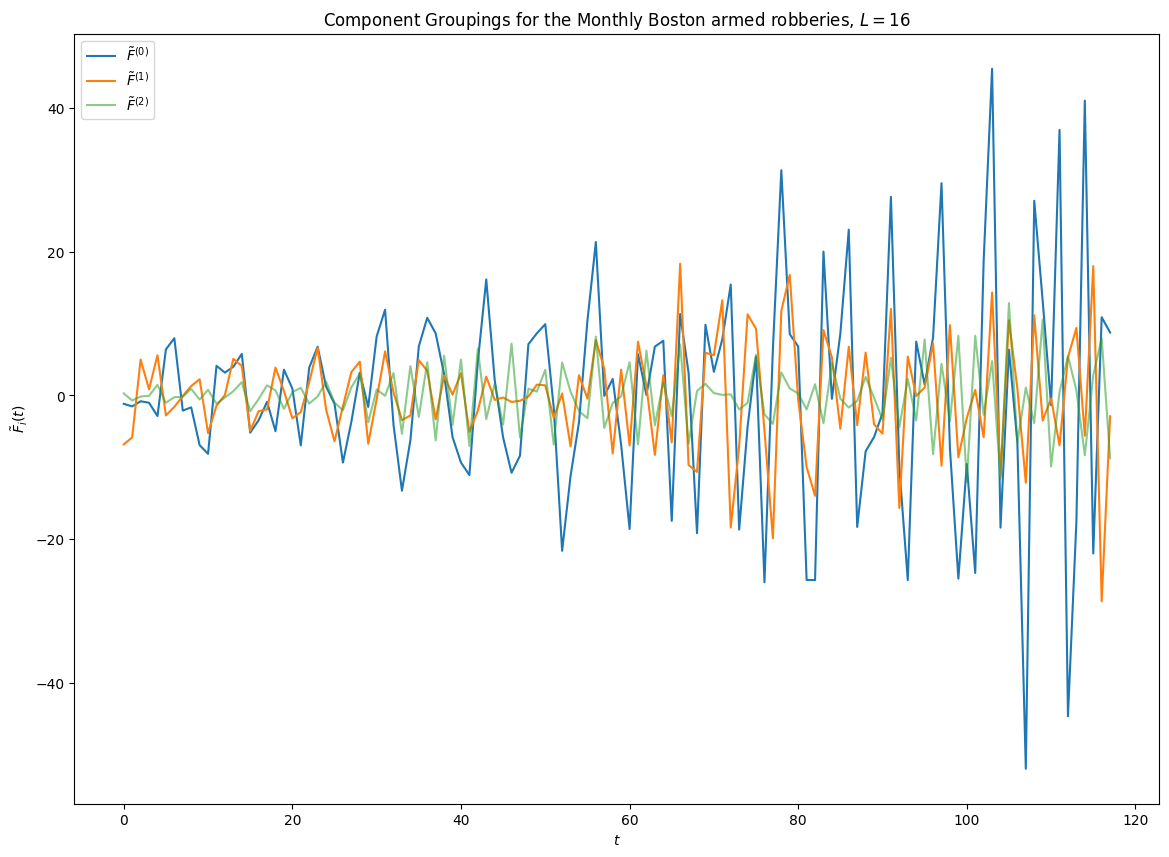

In [380]:
fig, ax = plt.subplots(figsize= (14, 10))

# boston_ts_16.reconstruct(0).plot(ax= ax)
# boston_ts_16.reconstruct([1, 2, 3]).plot(ax= ax)
boston_ts_16.reconstruct(slice(4, 8)).plot(ax= ax)
boston_ts_16.reconstruct(slice(9, 12)).plot(ax= ax)
boston_ts_16.reconstruct(slice(13, 15)).plot(alpha= .55, ax= ax)

plt.title("Component Groupings for the Monthly Boston armed robberies, $L=16$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(5)])

# **L = 32**

In [258]:
boston_ts_32 = SSA(tseries= series, L= 32)

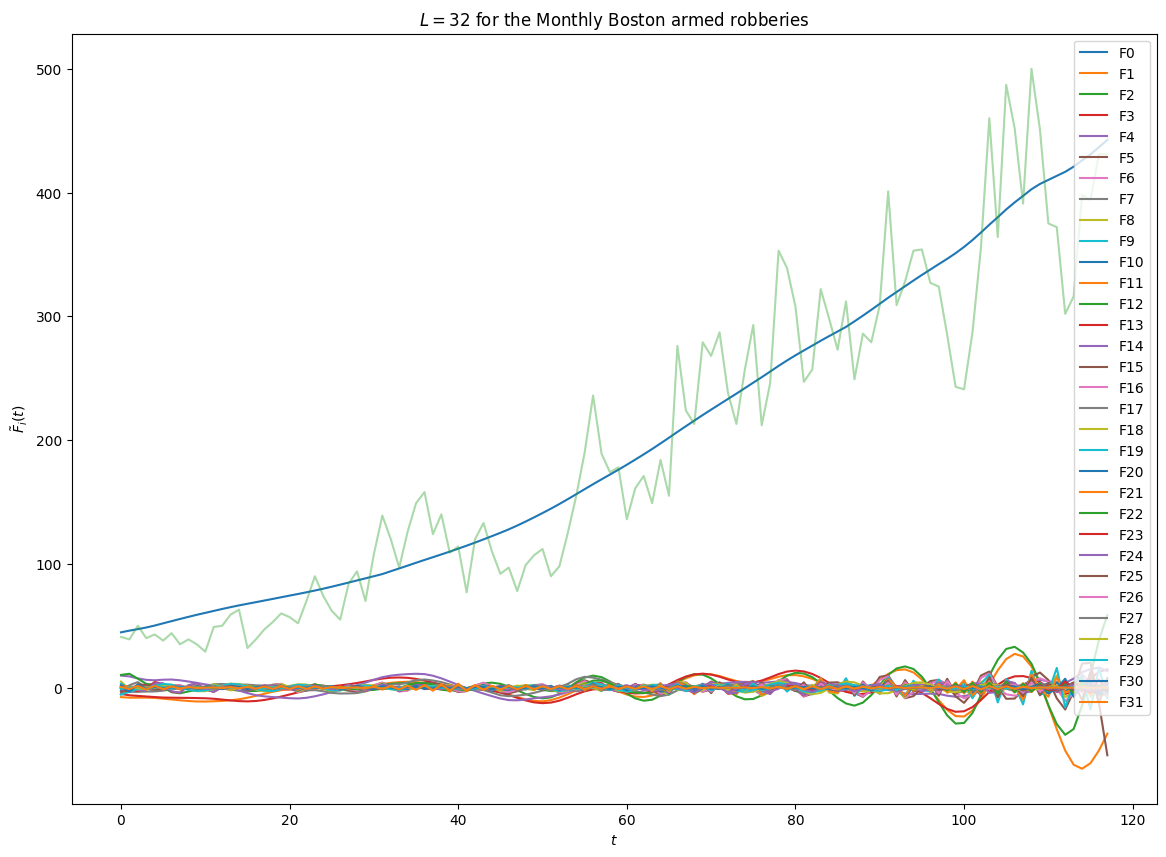

In [259]:
fig, ax = plt.subplots(figsize= (14, 10))

boston_ts_32.components_to_df().plot(ax= ax)
boston_ts_32.orig_TS.plot(ax= ax, alpha= .4)

ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tilde{F}_i(t)$")
ax.set_title(r"$L=32$ for the Monthly Boston armed robberies")

plt.show()

Text(0.5, 1.0, 'W-Correlation for the Monthly Boston armed robberies, $L=32$')

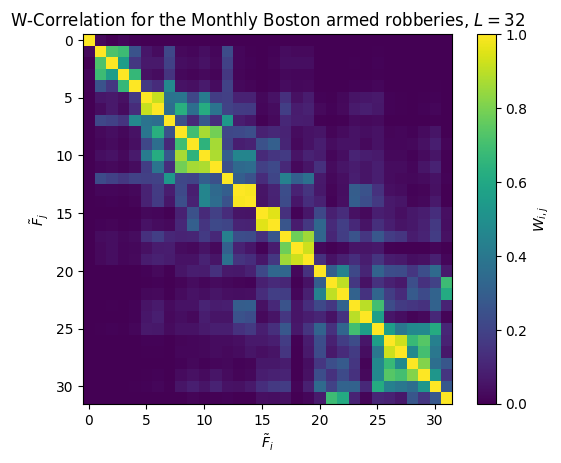

In [260]:
boston_ts_32.plot_wcorr()
plt.title("W-Correlation for the Monthly Boston armed robberies, $L=32$")

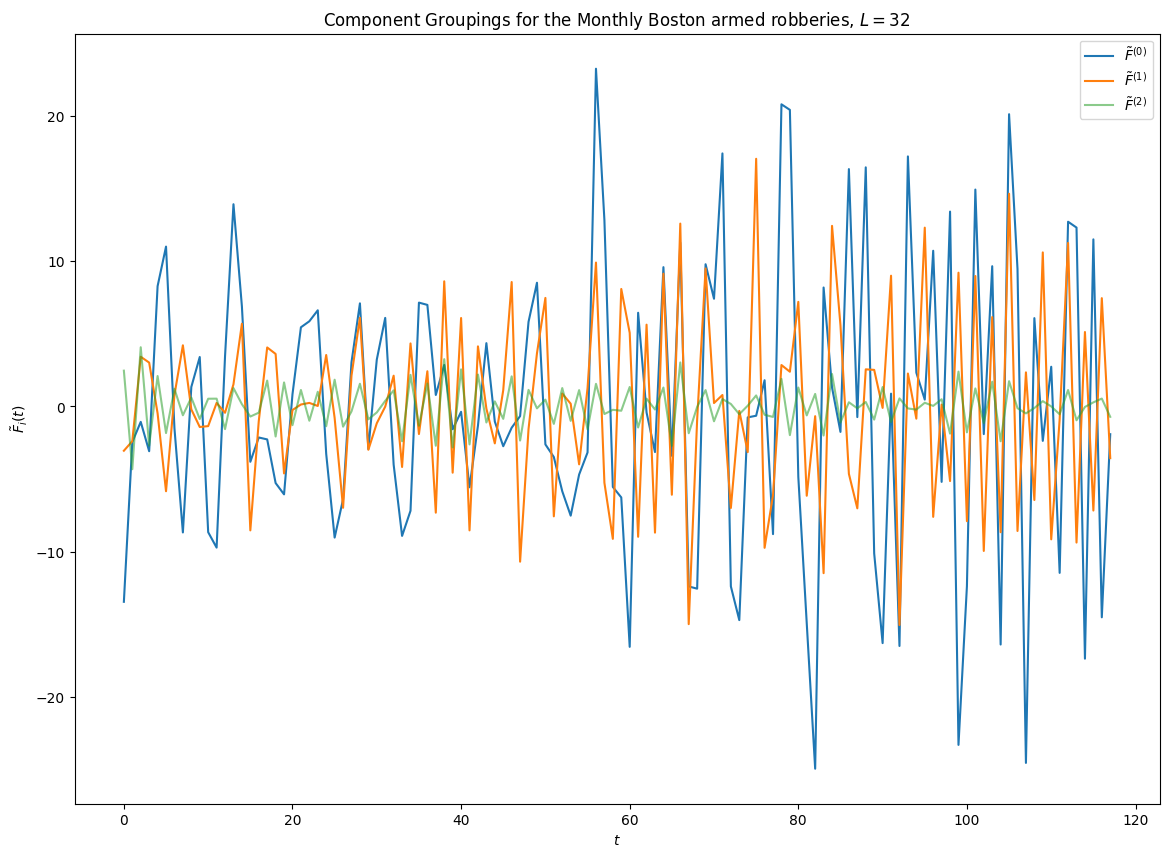

In [399]:
fig, ax = plt.subplots(figsize= (14, 10))

# boston_ts_32.reconstruct(0).plot(ax= ax)
# boston_ts_32.reconstruct([1, 2, 3]).plot(ax= ax)
# boston_ts_32.reconstruct(slice(4, 8)).plot(ax= ax)
# boston_ts_32.reconstruct(slice(9, 12)).plot(ax= ax)
boston_ts_32.reconstruct(slice(13, 20)).plot(ax= ax)
boston_ts_32.reconstruct(slice(21, 29)).plot(ax= ax)
boston_ts_32.reconstruct(slice(30, 32)).plot(alpha= .55, ax= ax)

plt.title("Component Groupings for the Monthly Boston armed robberies, $L=32$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(5)])

                    parameters         value
0               Test Statistic -1.175293e+01
1                      p-value  1.197221e-21
2                    Lags Used  2.300000e+01
3  Number of Observations Used  1.274000e+03
4          Critical Value (1%) -3.435493e+00
5          Critical Value (5%) -2.863811e+00
6         Critical Value (10%) -2.567979e+00


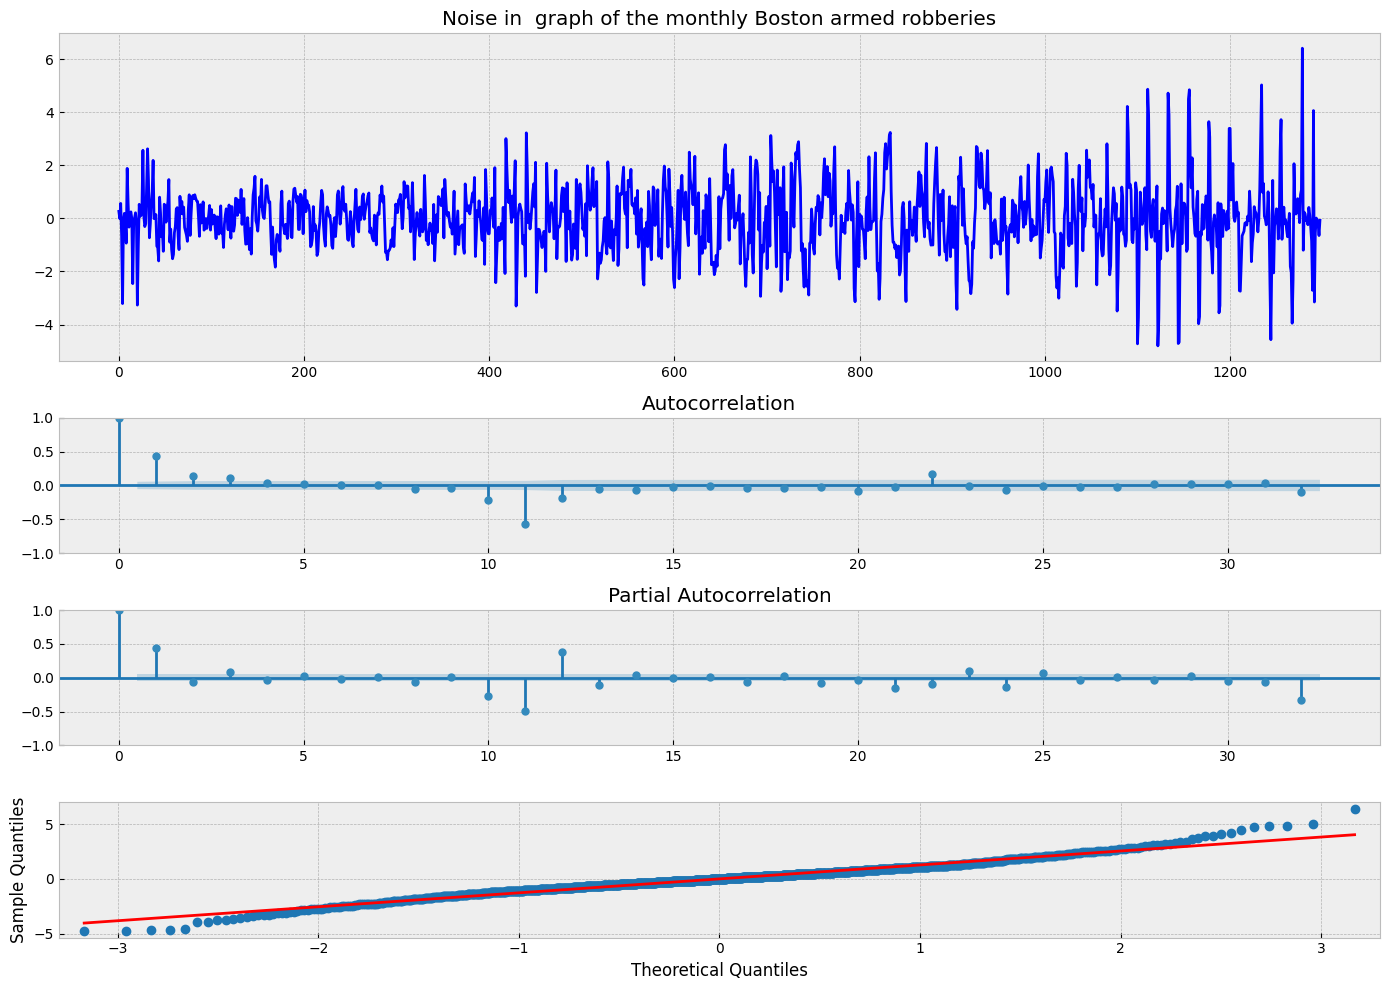

In [398]:
noise_plot = tsplot(boston_ts_32.components_to_df().iloc[:, 21:32].values.flatten(),
                    figsize= (14, 10),
                    plot_name= 'Noise in graph of the monthly Boston armed robberies')

In [390]:
variances = np.var(boston_ts_32.components_to_df(n= 20))
cumulative_variances = np.cumsum(np.var(boston_ts_32.components_to_df(n= 20)))

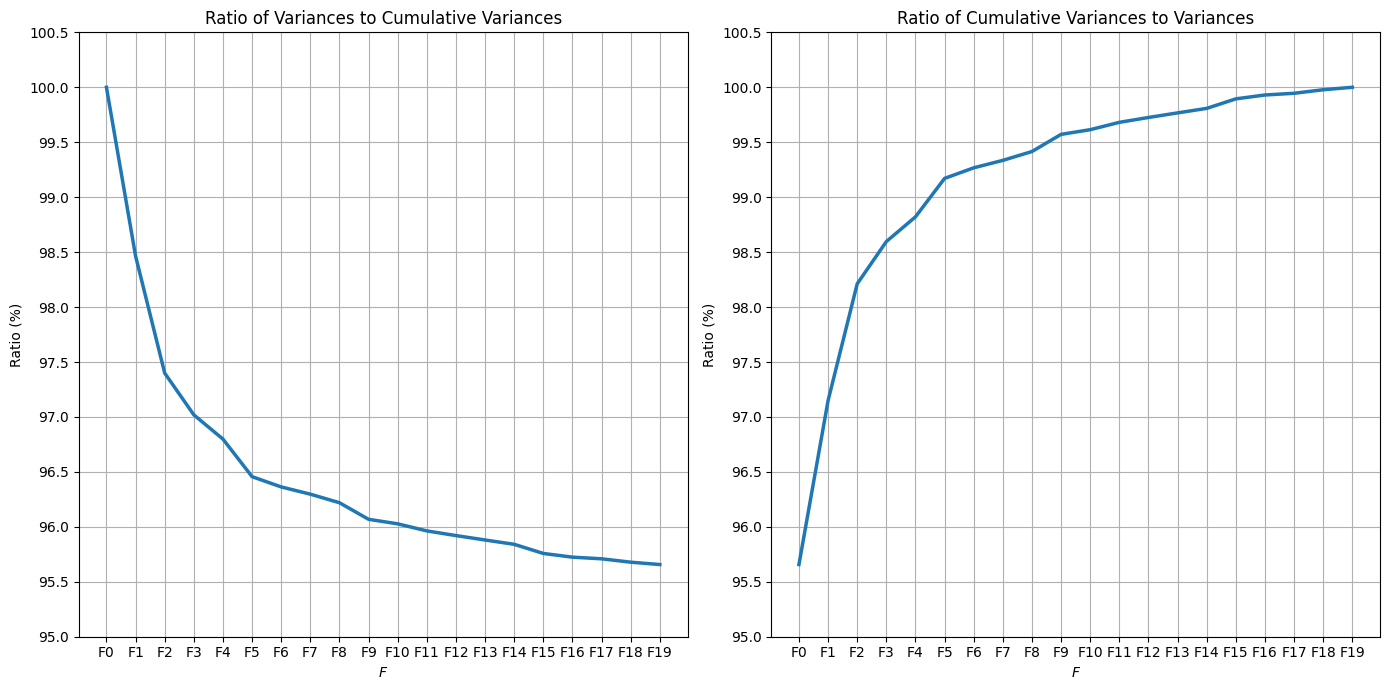

In [403]:
fig, ax = plt.subplots(1, 2, figsize= (14, 7))
ax[0].plot(variances[0] / cumulative_variances * 100, lw=2.5)
ax[0].set_title("Ratio of Variances to Cumulative Variances")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Ratio (%)")
ax[0].yaxis.set_ticks(np.arange(95, 101, .5))
ax[0].grid()

ax[1].plot(cumulative_variances / cumulative_variances[19] * 100, lw=2.5)
ax[1].set_title("Ratio of Cumulative Variances to Variances")
ax[1].set_xlabel("$F$")
ax[1].set_ylabel("Ratio (%)")
ax[1].yaxis.set_ticks(np.arange(95, 101, .5))
ax[1].grid()

plt.tight_layout()
plt.show()

                    parameters         value
0               Test Statistic -1.253949e+01
1                      p-value  2.331630e-23
2                    Lags Used  1.500000e+01
3  Number of Observations Used  2.200000e+02
4          Critical Value (1%) -3.460428e+00
5          Critical Value (5%) -2.874769e+00
6         Critical Value (10%) -2.573821e+00


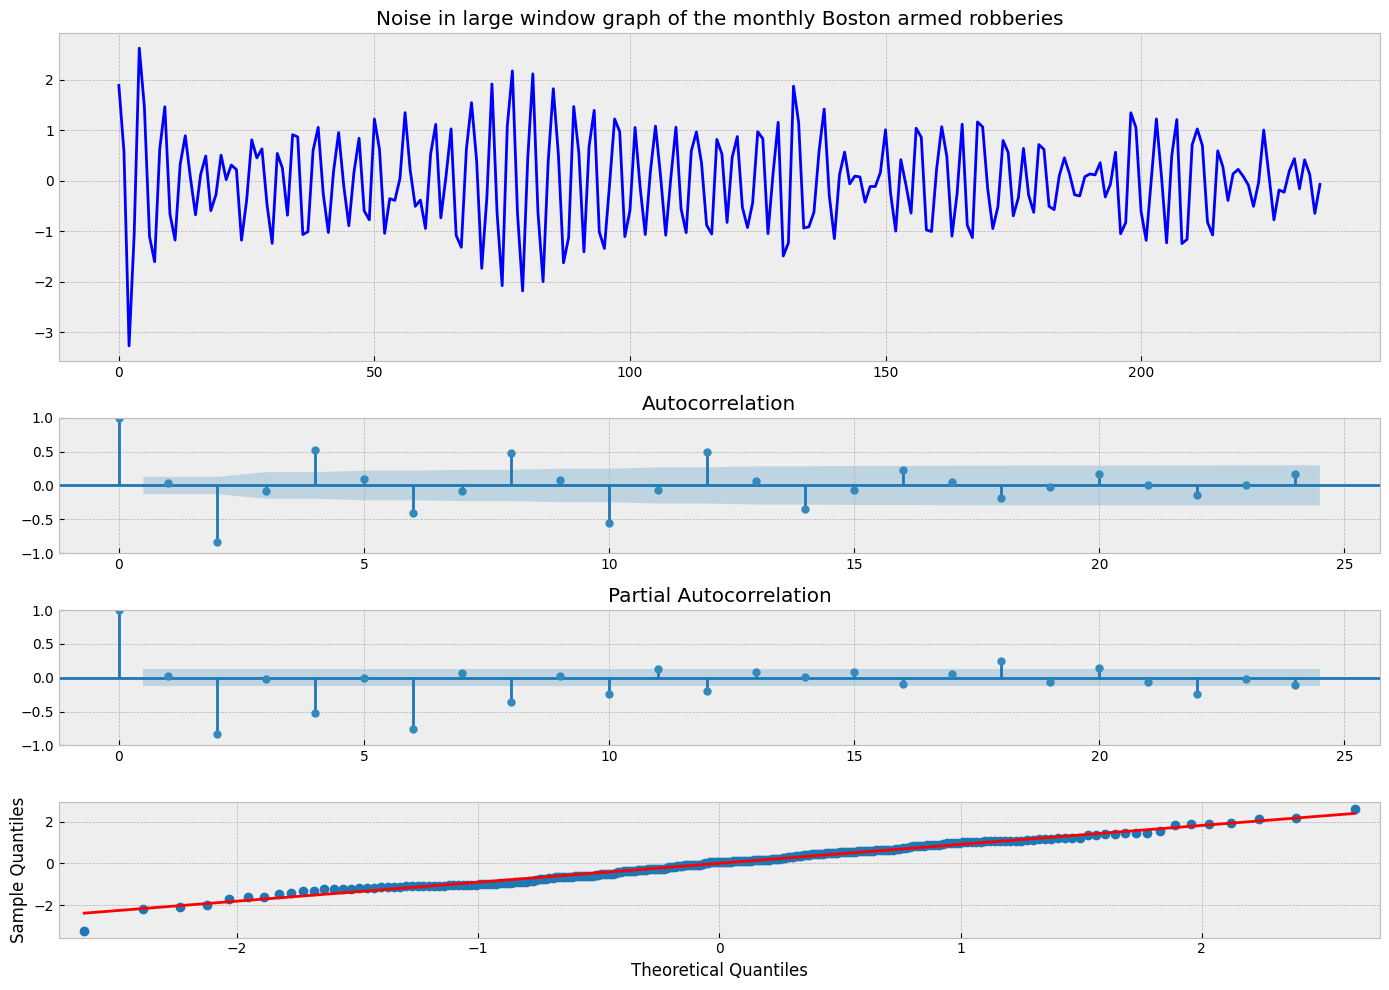

In [402]:
noise_plot = tsplot(boston_ts_32.components_to_df().iloc[:, 30:32].values.flatten(),
                    figsize= (14, 10),
                    plot_name= 'Noise in large window graph of the monthly Boston armed robberies')

# **Выводы:**
1. *Судя по графикам, максимально информативно описывают структуру ряда разложения с шириной окна L > 16.*
2. *Даже при ширине окна L = 32, в компонентах разложения с L [30; 32] все равно присутствует полезная информация, что говорит о том, что нужно больше данных, чтобы увеличить ширину окна для выявления полезных сигналов на этом уровне*